# Model training

## Load data

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model


In [17]:
outdir = "out_p_a1_given_q_xeff"
# import data
data = pd.read_pickle(f"{outdir}/p_a1_given_q_xeff.pkl")

In [18]:
data

,q,xeff,a1,p_a1
0,0.0,-1.0,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,0.0,-0.8,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,0.0,-0.6,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,0.0,-0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,0.0,-0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...
116,1.0,0.2,"[0.0, 0.002004008016032064, 0.0040080160320641...","[1.0680033419862862, 1.0678605941877117, 1.067..."
117,1.0,0.4,"[0.0, 0.002004008016032064, 0.0040080160320641...","[0.7832345001188603, 0.7843442342552497, 0.784..."
118,1.0,0.6,"[0.2064128256513026, 0.2080031807101176, 0.209...","[0.0003581317510958827, 0.0006423405154926148,..."
119,1.0,0.8,"[0.6112224448897795, 0.6120015582266737, 0.612...","[0.003378646421929789, 0.004692188317429458, 0..."


## Pre-processing

### Some data contains nans, drop them so that they wont cause problems later

In [19]:
data.drop([0,1,2,3,4,5,6,7,8,9,10,11,21,22,32,33,43,44,54,55,65,66,76,77,87,88,98,99,109,110,120], inplace=True)

In [20]:
data.reset_index(drop=True, inplace=True)

### Stupid way of getting everything to  numpy arrays with dtyoe = float64

In [21]:
a1 = []
for i in range(len(data)):
    a1.append(data['a1'][i])
a1 = np.array(a1)
p = []
for i in range(len(data)):
    p.append(data['p_a1'][i])
p = np.array(p)
q = data['q'].values
xeff = data['xeff'].values

In [22]:
# from sklearn.preprocessing import normalize
# p_norm = normalize(p,axis=0)

### Consider Normalizing the a1 and p

In [23]:
# from sklearn.preprocessing import MinMaxScaler
# scaler_a = MinMaxScaler()
# a1 = scaler_a.fit_transform(a1)
# scaler_p = MinMaxScaler()
# p = scaler_p.fit_transform(p)

### Spliting data into train and test

In [24]:
# split into train and test
from sklearn.model_selection import train_test_split
train_q, test_q, train_xeff, test_xeff, train_p, test_p, train_a1, test_a1 \
= train_test_split(q, xeff, p, a1,
 test_size=0.2, random_state=42)

### Pair q and xeff

In [25]:
train_q_xeff = np.stack((train_q, train_xeff), axis=1)

## Define evoluation function

In [33]:
def eva_model(model):
    # evaluate the model
    global test_a1
    global test_p
    global test_q_xeff
    scores = model.evaluate([test_q_xeff, test_a1], test_p)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    # plot history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoches')
    plt.ylabel('loss')
    plt.title('model loss')
    plt.show()
    #
    test_p_pred = model.predict([test_q_xeff, test_a1])
    # test_p_pred = scaler_p.inverse_transform(test_p_pred)
    # test_p = scaler_p.inverse_transform(test_p)
    # test_a1 = scaler_a.inverse_transform(test_a1)
    plt.plot(test_a1[3],test_p_pred[3],label = 'pred',color = 'red')
    plt.plot(test_a1[3],test_p[3],label = 'true',color = 'blue')
    plt.title(f'prediction vs true p_a1 for q = {test_q[3]}, xeff = {test_xeff[3]}')
    plt.legend()
    plt.xlabel('a1')
    plt.ylabel('p')
    plt.show()

    plt.plot(test_a1[8],test_p_pred[8],label = 'pred',color = 'red')
    plt.plot(test_a1[8],test_p[8],label = 'true',color = 'blue')
    plt.title(f'prediction vs true p_a1 for q = {test_q[5]}, xeff = {test_xeff[5]}')
    plt.legend()
    plt.xlabel('a1')
    plt.ylabel('p')
    plt.show()

## Define Model

In [27]:
# define model which take input of q, xeff, and a and output p
# input 2 numbers and 1 array, output 1 array with 500 elements
Input1 = keras.Input(shape=(2,)) # q, xeff
Input2 = keras.Input(shape=(500,)) # a1
merged = keras.layers.concatenate([Input1, Input2]) # Merging Laryer
# x = keras.layers.Dense(1024, activation='relu')(merged)
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation='relu',
 kernel_regularizer= keras.regularizers.L2(0.01))(merged) # Fully Connected Layer
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
output = keras.layers.Dense(500)(x) # Output

model = Model(inputs=[Input1,Input2], outputs=output)

In [28]:
opt = keras.optimizers.Adam(learning_rate = 3e-3)
model.compile(optimizer= opt,
                loss='mse',
                metrics= ['accuracy',])

history = model.fit([train_q_xeff,train_a1], train_p, validation_split=0.2,
                    epochs=500, batch_size=8, shuffle=True, verbose=2)

Epoch 1/500
8/8 - 1s - loss: 9.3352 - accuracy: 0.0000e+00 - val_loss: 4.2505 - val_accuracy: 0.0000e+00 - 772ms/epoch - 96ms/step
Epoch 2/500
8/8 - 0s - loss: 5.8435 - accuracy: 0.0000e+00 - val_loss: 2.9802 - val_accuracy: 0.0000e+00 - 44ms/epoch - 5ms/step
Epoch 3/500
8/8 - 0s - loss: 3.4088 - accuracy: 0.0000e+00 - val_loss: 6.3739 - val_accuracy: 0.0000e+00 - 46ms/epoch - 6ms/step
Epoch 4/500
8/8 - 0s - loss: 2.5591 - accuracy: 0.0000e+00 - val_loss: 19.6429 - val_accuracy: 0.2667 - 43ms/epoch - 5ms/step
Epoch 5/500
8/8 - 0s - loss: 2.1607 - accuracy: 0.0000e+00 - val_loss: 26.9073 - val_accuracy: 0.0000e+00 - 45ms/epoch - 6ms/step
Epoch 6/500
8/8 - 0s - loss: 2.0473 - accuracy: 0.0000e+00 - val_loss: 32.1944 - val_accuracy: 0.0000e+00 - 40ms/epoch - 5ms/step
Epoch 7/500
8/8 - 0s - loss: 1.9310 - accuracy: 0.0000e+00 - val_loss: 39.9401 - val_accuracy: 0.0000e+00 - 36ms/epoch - 5ms/step
Epoch 8/500
8/8 - 0s - loss: 2.5686 - accuracy: 0.0175 - val_loss: 37.4901 - val_accuracy: 0.00

In [29]:
test_q_xeff = np.stack((test_q, test_xeff), axis=1)

1/1 [==============================] - 0s 19ms/step - loss: 1.1650 - accuracy: 0.4444
accuracy: 44.44%


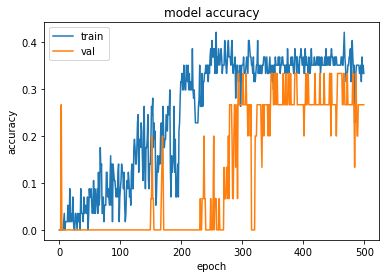

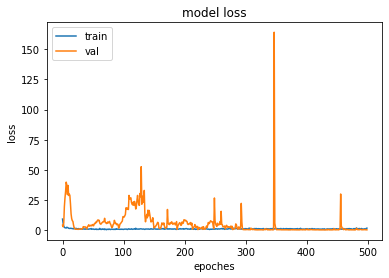

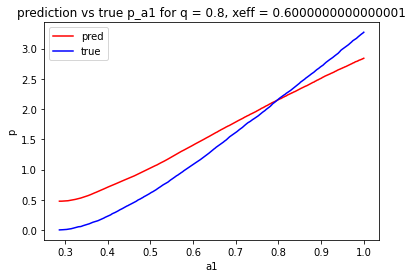

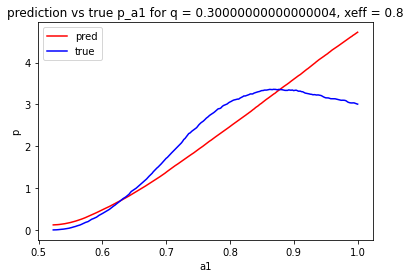

In [34]:
eva_model(model)